In [17]:
import cudf
import pandas as pd

import cuml
from cupy import asnumpy
from joblib import dump, load

from sklearn.metrics import accuracy_score


import cupy as cp
import matplotlib.pyplot as plt
# import seaborn as sns
from cuml.model_selection import train_test_split
from cuml.linear_model import LogisticRegression as cuLogisticRegression
from cuml.ensemble import RandomForestClassifier as cuRandomForestClassifier
from cuml.ensemble import RandomForestRegressor as cuRandomForestRegressor
from cuml.naive_bayes import GaussianNB as cuGaussianNB
from cuml.svm import SVC as cuSVC
from cuml.metrics import accuracy_score as cu_accuracy_score
from cuml.pipeline import Pipeline as cuPipeline
from cuml.compose import ColumnTransformer as cuColumnTransformer
from cuml.preprocessing import StandardScaler as cuStandardScaler
from cuml.preprocessing import OneHotEncoder as cuOneHotEncoder
from cuml.cluster import KMeans as cuKMeans

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_auc_score, roc_curve, auc, mean_squared_error, r2_score

# from imblearn.over_sampling import SMOTE
# from imblearn.pipeline import Pipeline as ImbPipeline

from tqdm import tqdm
from itertools import product

In [3]:
# Load data with cuDF
data = cudf.read_csv("data/CompleteDataset.csv").drop(columns=["Unnamed: 0"]).dropna()
data = data.drop(columns=['Photo', 'Flag', 'Club Logo'])
data.head()

,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Acceleration,...,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
0,Cristiano Ronaldo,32,Portugal,94,94,Real Madrid CF,€95.5M,€565K,2228,89,...,61.0,53.0,82.0,62.0,91.0,89.0,92.0,91.0,66.0,92.0
1,L. Messi,30,Argentina,93,93,FC Barcelona,€105M,€565K,2154,92,...,57.0,45.0,84.0,59.0,92.0,90.0,88.0,91.0,62.0,88.0
2,Neymar,25,Brazil,92,94,Paris Saint-Germain,€123M,€280K,2100,94,...,59.0,46.0,79.0,59.0,88.0,87.0,84.0,89.0,64.0,84.0
3,L. Suárez,30,Uruguay,92,92,FC Barcelona,€97M,€510K,2291,88,...,64.0,58.0,80.0,65.0,88.0,85.0,88.0,87.0,68.0,88.0
5,R. Lewandowski,28,Poland,91,91,FC Bayern Munich,€92M,€355K,2143,79,...,58.0,57.0,78.0,62.0,87.0,82.0,88.0,84.0,61.0,88.0


In [4]:
def value_to_float(df, column):
    # Remove '€'
    df[column] = df[column].str.replace('€', '')
    # Replace 'M' with 'e6' and 'K' with 'e3' for scientific notation
    df[column] = df[column].str.replace('M', 'e6').str.replace('K', 'e3')
    # Convert to float
    df[column] = df[column].astype('float64')
    return df

def clean_stat(df, column):
    df[f'{column}_base'] = df[column].str.extract(r'(\d+)').astype('int32')
    df[f'{column}_mod'] = 0
    df.loc[df[column].str.endswith('+'), f'{column}_mod'] = 1
    df.loc[df[column].str.endswith('-'), f'{column}_mod'] = -1
    df[column] = df[f'{column}_base'] + df[f'{column}_mod']
    df = df.drop(columns=[f'{column}_base', f'{column}_mod'])
    return df

def create_features(data):
    df = data.copy()
    df['Preferred Positions'] = df['Preferred Positions'].astype('str').fillna('')

    columns_with_issues = [
        'Finishing', 'Composure', 'Dribbling', 'Shot power', 
        'Standing tackle', 'Marking', 'Interceptions', 'Strength', 
        'Stamina', 'Jumping', 'Ball control', 'Short passing'
    ]
    for c in columns_with_issues:
        df = clean_stat(df, c)

    df = value_to_float(df, 'Value')
    df = value_to_float(df, 'Wage')

    df['Primary Position'] = df['Preferred Positions'].str.extract(r'^(\S+)')
    df['Secondary Positions'] = df['Preferred Positions'].str.extract(r'^\S+\s+(.*)$').fillna('')
    
    df['Attacking Score'] = df[['Finishing', 'Dribbling', 'Shot power']].mean(axis=1)
    df['Defensive Score'] = df[['Standing tackle', 'Marking', 'Interceptions']].mean(axis=1)
    df['Attack/Defend Ratio'] = df['Attacking Score'] / df['Defensive Score']

    df['isAttacker'] = (df['Attack/Defend Ratio'] > 1).astype('int32')



    df['Physical Index'] = df[['Strength', 'Stamina', 'Jumping']].mean(axis=1)
    df['Technical Skill'] = df[['Ball control', 'Dribbling', 'Short passing']].mean(axis=1)

    # df['Value per Overall'] = df['Value'] / df['Overall']
    # df['Wage per Overall'] = df['Wage'] / df['Overall']

    # df['Potential Gap'] = df['Potential'] - df['Overall']

    df['Age Group'] = cudf.Series(pd.cut(
        df['Age'].to_pandas(), 
        bins=[15, 20, 25, 30, 40, 50], 
        labels=['Teen', 'Young', 'Prime', 'Veteran', 'Legend']
    ))

    # Additional composite scores
    df['Scoring Under Pressure'] = df['Finishing'] * df['Composure']
    # df['GK Score'] = df[['GK diving', 'GK reflexes', 'GK positioning']].mean(axis=1)

    # KMeans clustering for 'Player Archetype'
    # kmeans = cuKMeans(n_clusters=5, random_state=0)
    # df['Player Archetype'] = kmeans.fit_predict(df[['Overall', 'Potential', 'Value', 'Wage', 'Age']])

    # Remove duplicates
    df.drop_duplicates(inplace=True)

    return df.reset_index(drop=True)

In [ ]:
df = create_features(data)

target = 'Overall'
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=['int64', 'int32', 'float64']).columns

subset_frac = 0.1

# Only keep the numerical columns for now
df = df[numerical_cols]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=target).sample(frac=subset_frac, random_state=42), 
    df[target].sample(frac=subset_frac, random_state=42), 
    # stratify=df[target].sample(frac=subset_frac, random_state=42), 
    random_state=42
)

In [9]:
X_train.head(2)

,Age,Potential,Value,Wage,Special,Ball control,Composure,Dribbling,Finishing,Interceptions,...,RW,RWB,ST,Attacking Score,Defensive Score,Attack/Defend Ratio,isAttacker,Physical Index,Technical Skill,Scoring Under Pressure
5497,28.0,69.0,1100000.0,10000.0,1826.0,68.0,65.0,64.0,74.0,49.0,...,67.0,56.0,70.0,69.000000,43.666667,1.580153,1.0,68.666667,66.666667,4810.0
1350,26.0,77.0,9000000.0,43000.0,1785.0,82.0,61.0,78.0,63.0,23.0,...,76.0,57.0,65.0,68.333333,25.666667,2.662338,1.0,56.000000,79.000000,3843.0


In [11]:
categorical_cols = categorical_cols.drop(target, errors='ignore')
numerical_cols = numerical_cols.drop(target, errors='ignore')

numerical_transformer = cuStandardScaler()
categorical_transformer = cuOneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = cuColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        # ('cat', categorical_transformer, categorical_cols)
    ]
)

# 6. Define Pipeline with RandomForestClassifier
pipeline = cuPipeline(steps=[
    ('preprocessor', preprocessor),
    # ('classifier', cuRandomForestClassifier())
])

In [12]:
pipeline.fit(X_train, y_train)

X_train_encoded = pipeline.fit_transform(X_train, y_train)
X_train_encoded.columns = X_train.columns
X_test_encoded = pipeline.fit_transform(X_test)

In [1]:
X_train_encoded.head(2)

NameError: name 'X_train_encoded' is not defined

/home/vnazza/miniforge3/envs/rapids-24.10/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/vnazza/miniforge3/envs/rapids-24.10/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


SKLearn MSE : 2.500477598151829
SKLearn R2 : 0.9488741664095852


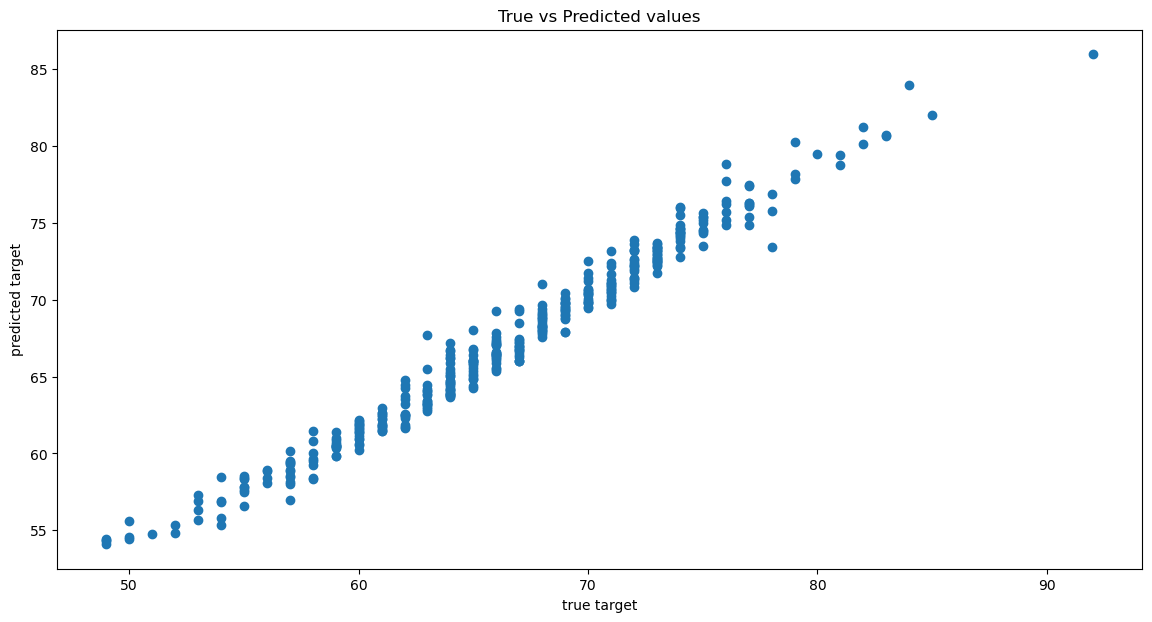

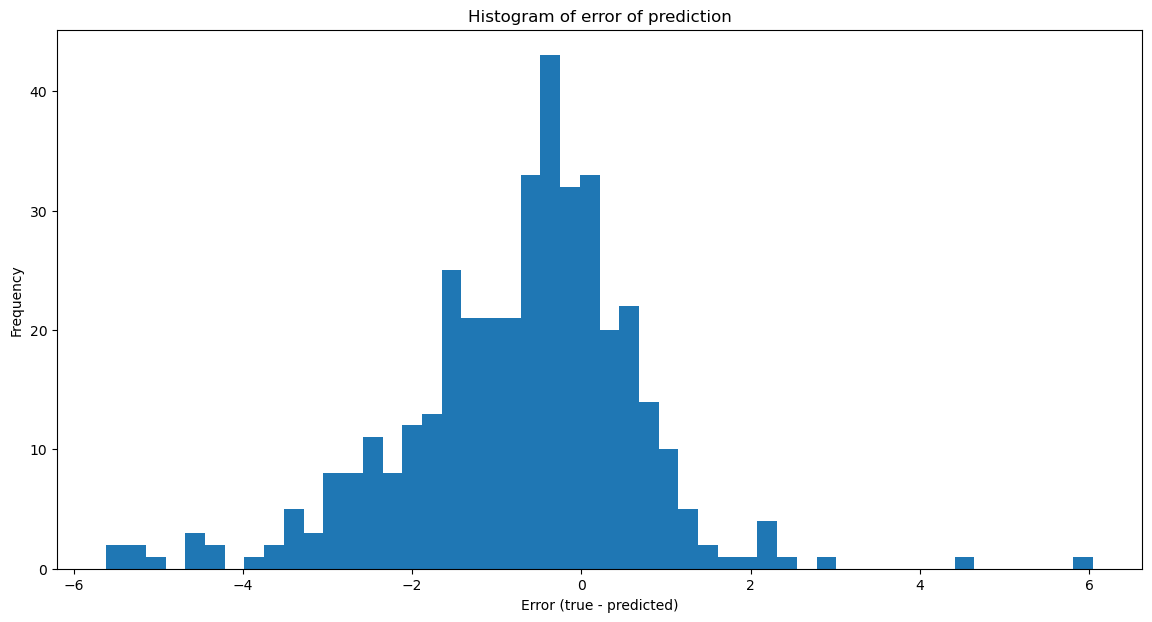

In [ ]:
model = cuRandomForestRegressor( max_depth = 10,
              n_estimators = 25,
              random_state  = 0 )

trained_RF = model.fit ( X_train_encoded, y_train )

predictions = model.predict ( X_test_encoded )


sk_mse = mean_squared_error(asnumpy(y_test), asnumpy(predictions))
sk_r2 = r2_score(asnumpy(y_test), asnumpy(predictions))
print("SKLearn MSE :", sk_mse)
print("SKLearn R2 :", sk_r2)

plt.figure(figsize=(14, 7))
plt.scatter(asnumpy(y_test), asnumpy(predictions))
plt.line(0)
plt.xlabel('true target')
plt.ylabel('predicted target')
plt.title('True vs Predicted values')
plt.show()

plt.figure(figsize=(14, 7))
plt.hist(asnumpy(y_test)-asnumpy(predictions), bins=50)
plt.xlabel("Error (true - predicted)")
plt.ylabel('Number of occurences')
plt.title('Histogram of error of prediction')
plt.show()

# cu_score = cuml.metrics.accuracy_score( y_test, predictions )
# sk_score = accuracy_score( asnumpy( y_test ), asnumpy( predictions ) )

# print( " cuml accuracy: ", cu_score )
# print( " sklearn accuracy : ", sk_score )

  0%|          | 0/3 [00:00<?, ?it/s]/home/vnazza/miniforge3/envs/rapids-24.10/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)



--- Training RandomForest ---


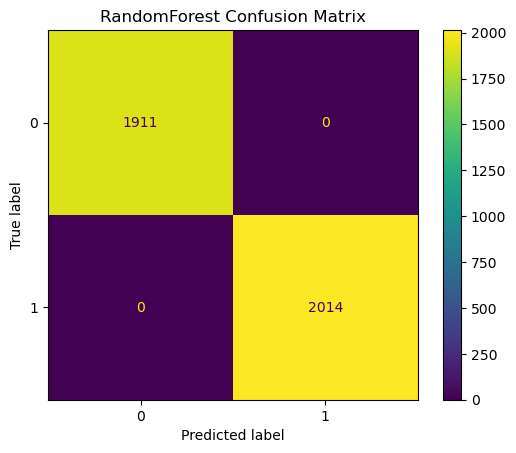

  0%|          | 0/3 [00:00<?, ?it/s]

RandomForest - cuML Accuracy: 1.0000
RandomForest - sklearn Accuracy: 1.0000
Recall: 1.0000
F1-Score: 1.0000
ROC-AUC: 1.0000


ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
import cudf
import pandas as pd

import cuml
from cupy import asnumpy
from joblib import dump, load

from cuml.model_selection import StratifiedKFold
from cuml.datasets.classification import make_classification
from cuml.model_selection import train_test_split
from cuml.ensemble import RandomForestClassifier as cuRandomForestClassifier
from cuml.naive_bayes import GaussianNB as cuGaussianNB  # This causes issues w/ GaussianNB
from cuml.svm import SVC as cuSVC
from cuml.metrics import accuracy_score as cu_accuracy_score
from cuml.pipeline import Pipeline as cuPipeline
from cuml.compose import ColumnTransformer as cuColumnTransformer
from cuml.preprocessing import StandardScaler as cuStandardScaler
from cuml.preprocessing import OneHotEncoder as cuOneHotEncoder

from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB  # for GaussianNB
from sklearn.pipeline import Pipeline as skPipeline
from tqdm import tqdm
from itertools import product

import matplotlib.pyplot as plt

data = cudf.read_csv("data/CompleteDataset.csv").drop(columns=["Unnamed: 0"]).dropna()
data = data.drop(columns=['Photo', 'Flag', 'Club Logo'])

def value_to_float(df, column):
    df[column] = df[column].str.replace('€', '', regex=False)\
                               .str.replace('M', 'e6', regex=False)\
                               .str.replace('K', 'e3', regex=False)
    df[column] = df[column].astype('float64')
    return df

def clean_stat(df, column):
    df[column] = df[column].str.extract(r'(\d+)').astype('int32')
    return df

def create_features(data):
    df = data.copy()

    df['Preferred Positions'] = df['Preferred Positions'].astype('str').fillna('')

    columns_with_issues = [
        'Finishing', 'Composure', 'Dribbling', 'Shot power', 
        'Standing tackle', 'Marking', 'Interceptions', 'Strength', 
        'Stamina', 'Jumping', 'Ball control', 'Short passing'
    ]

    for c in columns_with_issues:
        df = clean_stat(df, c)

    monetary_columns = ['Value', 'Wage']
    for col in monetary_columns:
        df = value_to_float(df, col)

    df['Primary Position'] = df['Preferred Positions'].str.extract(r'^(\S+)')
    df['Secondary Positions'] = df['Preferred Positions'].str.extract(r'^\S+\s+(.*)$').fillna('')

    df['Attacking Score'] = df[['Finishing', 'Dribbling', 'Shot power']].mean(axis=1)
    df['Defensive Score'] = df[['Standing tackle', 'Marking', 'Interceptions']].mean(axis=1)
    df['Attack/Defend Ratio'] = df['Attacking Score'] / df['Defensive Score']
    df['isAttacker'] = (df['Attack/Defend Ratio'] > 1).astype('int32')
    df['Physical Index'] = df[['Strength', 'Stamina', 'Jumping']].mean(axis=1)
    df['Technical Skill'] = df[['Ball control', 'Dribbling', 'Short passing']].mean(axis=1)
    df['Value per Overall'] = df['Value'] / df['Overall']
    df['Wage per Overall'] = df['Wage'] / df['Overall']
    df['Potential Gap'] = df['Potential'] - df['Overall']

    df['Age Group'] = cudf.Series(pd.cut(
        df['Age'].to_pandas(), 
        bins=[15, 20, 25, 30, 40, 50], 
        labels=['Teen', 'Young', 'Prime', 'Veteran', 'Legend']
    ))

    df['Scoring Under Pressure'] = df['Finishing'] * df['Composure']
    df.drop_duplicates(inplace=True)
    return df.reset_index(drop=True)

df = create_features(data)

target = 'isAttacker'
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=['int64', 'int32', 'float64']).columns

df = df[numerical_cols]

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=target), 
    df[target], 
    stratify=df[target], 
    random_state=42
)

categorical_cols = categorical_cols.drop(target, errors='ignore')
numerical_cols = numerical_cols.drop(target, errors='ignore')

y_train = y_train.astype('int32')
y_test = y_test.astype('int32')

numerical_transformer = cuStandardScaler()
# categorical_transformer = cuOneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor_cuml = cuColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        # ('cat', categorical_transformer, categorical_cols)
    ]
)

from sklearn.preprocessing import StandardScaler as skStandardScaler
from sklearn.compose import ColumnTransformer as skColumnTransformer

preprocessor_cpu = skColumnTransformer(
    transformers=[
        ('num', skStandardScaler(), numerical_cols),
        # ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

numerical_transformer_sklearn = skStandardScaler()
preprocessor_sklearn = skColumnTransformer(
    transformers=[
        ('num', numerical_transformer_sklearn, numerical_cols),
        # ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

classifiers = {
    'RandomForest': cuRandomForestClassifier(max_depth=10, n_estimators=25),
    'GaussianNB': GaussianNB(),
    'SVC': cuSVC()
}

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def train_evaluate_model(model_name, model, X_train, y_train, X_test, y_test):
    print(f"\n--- Training {model_name} ---")
    
    try:
        if model_name == 'GaussianNB':
            pipeline = skPipeline(steps=[
                ('preprocessor', preprocessor_cpu),
                ('classifier', model)
            ])
        else:
            pipeline = cuPipeline(steps=[
                ('preprocessor', preprocessor_cuml),
                ('classifier', model)
            ])
        
        pipeline.fit(X_train, y_train)
        predictions = pipeline.predict(X_test)
        
        if model_name == 'GaussianNB':
            # Convert cuDF to pandas for scikit-learn
            X_train_pd = X_train.to_pandas()
            X_test_pd = X_test.to_pandas()
            y_train_pd = y_train.to_pandas()
            y_test_pd = y_test.to_pandas()

            print(y_test_pd)

            
            
            # Create scikit-learn pipeline
            pipeline = skPipeline(steps=[
                ('preprocessor', preprocessor_sklearn),
                ('classifier', model)
            ])
            
            # Fit the model
            pipeline.fit(X_train_pd, y_train_pd)
            
            # Predict on test data
            predictions = pipeline.predict(X_test_pd)
            
            # Calculate metrics using scikit-learn
            cu_score = accuracy_score(y_test_pd, predictions)
            sk_score = accuracy_score(y_test_pd, predictions)
            recall = recall_score(y_test_pd, predictions)
            f1 = f1_score(y_test_pd, predictions)
            roc_auc = roc_auc_score(y_test_pd, predictions)
            
            # Confusion Matrix
            cm = confusion_matrix(y_test_pd.to_numpy(), predictions.to_numpy())
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            disp.plot()
            plt.title(f"{model_name} Confusion Matrix")
            plt.show()
        else:
            cu_score = cu_accuracy_score(y_test, predictions)
            sk_score = accuracy_score(asnumpy(y_test), asnumpy(predictions))
            
            recall = recall_score(asnumpy(y_test), asnumpy(predictions))
            f1 = f1_score(asnumpy(y_test), asnumpy(predictions))
            roc_auc = roc_auc_score(asnumpy(y_test), asnumpy(predictions))
            
            cm = confusion_matrix(asnumpy(y_test), asnumpy(predictions))
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            disp.plot()
            plt.title(f"{model_name} Confusion Matrix")
            plt.show()
        
        print(f"{model_name} - cuML Accuracy: {cu_score:.4f}")
        print(f"{model_name} - sklearn Accuracy: {sk_score:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"ROC-AUC: {roc_auc:.4f}")
    
    except Exception as e:
        print(f"Error with {model_name}: {e}")


for model_name, model in tqdm(classifiers.items()):
    train_evaluate_model(model_name, model, X_train, y_train, X_test, y_test)


In [ ]:
import cudf
import pandas as pd
import cuml
from cupy import asnumpy
from joblib import dump, load
from cuml.model_selection import StratifiedKFold
from cuml.model_selection import train_test_split as cu_train_test_split
from cuml.ensemble import RandomForestClassifier as cuRandomForestClassifier
from cuml.svm import SVC as cuSVC
from cuml.metrics import accuracy_score as cu_accuracy_score
from cuml.pipeline import Pipeline as cuPipeline
from cuml.compose import ColumnTransformer as cuColumnTransformer
from cuml.preprocessing import StandardScaler as cuStandardScaler
from cuml.preprocessing import OneHotEncoder as cuOneHotEncoder
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay
from sklearn.naive_bayes import GaussianNB  # Using scikit-learn's GaussianNB
from sklearn.pipeline import Pipeline as skPipeline
from sklearn.preprocessing import StandardScaler as skStandardScaler
from sklearn.compose import ColumnTransformer as skColumnTransformer
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# Create directories for saving plots
os.makedirs('confusion_matrices', exist_ok=True)
os.makedirs('roc_curves', exist_ok=True)

# 1. Load and Preprocess Data
data = cudf.read_csv("data/CompleteDataset.csv").drop(columns=["Unnamed: 0"]).dropna()
data = data.drop(columns=['Photo', 'Flag', 'Club Logo'])

def value_to_float(df, column):
    df[column] = df[column].str.replace('€', '', regex=False)\
                               .str.replace('M', 'e6', regex=False)\
                               .str.replace('K', 'e3', regex=False)
    df[column] = df[column].astype('float64')
    return df

def clean_stat(df, column):
    df[column] = df[column].str.extract(r'(\d+)').astype('int32')
    return df

def create_features(data):
    df = data.copy()

    df['Preferred Positions'] = df['Preferred Positions'].astype('str').fillna('')

    columns_with_issues = [
        'Finishing', 'Composure', 'Dribbling', 'Shot power', 
        'Standing tackle', 'Marking', 'Interceptions', 'Strength', 
        'Stamina', 'Jumping', 'Ball control', 'Short passing'
    ]

    for c in columns_with_issues:
        df = clean_stat(df, c)

    monetary_columns = ['Value', 'Wage']
    for col in monetary_columns:
        df = value_to_float(df, col)

    df['Primary Position'] = df['Preferred Positions'].str.extract(r'^(\S+)')
    df['Secondary Positions'] = df['Preferred Positions'].str.extract(r'^\S+\s+(.*)$').fillna('')

    df['Attacking Score'] = df[['Finishing', 'Dribbling', 'Shot power']].mean(axis=1)
    df['Defensive Score'] = df[['Standing tackle', 'Marking', 'Interceptions']].mean(axis=1)
    df['Attack/Defend Ratio'] = df['Attacking Score'] / df['Defensive Score']
    df['isAttacker'] = (df['Attack/Defend Ratio'] > 1).astype('int32')

    df = df.drop(columns=['Attacking Score', 'Defensive Score', 'Attack/Defend Ratio'])

    df['Physical Index'] = df[['Strength', 'Stamina', 'Jumping']].mean(axis=1)
    df['Technical Skill'] = df[['Ball control', 'Dribbling', 'Short passing']].mean(axis=1)
    df['Value per Overall'] = df['Value'] / df['Overall']
    df['Wage per Overall'] = df['Wage'] / df['Overall']
    df['Potential Gap'] = df['Potential'] - df['Overall']

    df['Age Group'] = cudf.Series(pd.cut(
        df['Age'].to_pandas(), 
        bins=[15, 20, 25, 30, 40, 50], 
        labels=['Teen', 'Young', 'Prime', 'Veteran', 'Legend']
    ))

    df['Scoring Under Pressure'] = df['Finishing'] * df['Composure']
    df.drop_duplicates(inplace=True)
    return df.reset_index(drop=True)

df = create_features(data)

target = 'isAttacker'
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=['int64', 'int32', 'float64']).columns

df = df[numerical_cols]

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=target), 
    df[target], 
    stratify=df[target], 
    random_state=42
)
categorical_cols = categorical_cols.drop(target, errors='ignore')
numerical_cols = numerical_cols.drop(target, errors='ignore')

y_train = y_train.astype('int32')
y_test = y_test.astype('int32')


numerical_transformer_cuml = cuStandardScaler()
# categorical_transformer = cuOneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor_cuml = cuColumnTransformer(
    transformers=[
        ('num', numerical_transformer_cuml, numerical_cols)
        # ('cat', categorical_transformer, categorical_cols)
    ]
)

numerical_transformer_sklearn = skStandardScaler()
preprocessor_sklearn = skColumnTransformer(
    transformers=[
        ('num', numerical_transformer_sklearn, numerical_cols)
        # ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

classifiers = {
    'RandomForest': cuRandomForestClassifier(max_depth=10, n_estimators=25),
    'GaussianNB': GaussianNB(),
    'SVC': cuSVC()
}

metrics_list = []
def train_evaluate_model(model_name, model, X_train, y_train, X_test, y_test):
    print(f"\n--- Training {model_name} ---")
    
    try:
        if model_name == 'GaussianNB':
            X_train_pd = X_train.to_pandas()
            X_test_pd = X_test.to_pandas()
            y_train_pd = y_train.to_pandas()
            y_test_pd = y_test.to_pandas()
            
            pipeline = skPipeline(steps=[
                ('preprocessor', preprocessor_sklearn),
                ('classifier', model)
            ])
            
            pipeline.fit(X_train_pd, y_train_pd)
            predictions = pipeline.predict(X_test_pd)
            
            cu_score = accuracy_score(y_test_pd, predictions)
            sk_score = accuracy_score(y_test_pd, predictions)
            recall = recall_score(y_test_pd, predictions)
            f1 = f1_score(y_test_pd, predictions)
            roc_auc = roc_auc_score(y_test_pd, predictions)
            
            cm = confusion_matrix(y_test_pd, predictions)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            disp.plot()
            plt.title(f"{model_name} Confusion Matrix")
            plt.savefig(f"confusion_matrices/{model_name}_confusion_matrix.png")
            plt.close()
            
            fpr, tpr, thresholds = roc_curve(y_test_pd, predictions)
            roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=model_name)
            roc_display.plot()
            plt.title(f"{model_name} ROC Curve")
            plt.savefig(f"roc_curves/{model_name}_roc_curve.png")
            plt.close()
            
            metrics_list.append({
                'Model': model_name,
                'Accuracy': cu_score,
                'sklearn Accuracy': sk_score,
                'Recall': recall,
                'F1-Score': f1,
                'ROC-AUC': roc_auc
            })
            
        else:
            pipeline = cuPipeline(steps=[
                ('preprocessor', preprocessor_cuml),
                ('classifier', model)
            ])
            
            pipeline.fit(X_train, y_train)
            predictions = pipeline.predict(X_test)
            
            cu_score = cu_accuracy_score(y_test, predictions)
            
            sk_score = accuracy_score(asnumpy(y_test), asnumpy(predictions))
            recall = recall_score(asnumpy(y_test), asnumpy(predictions))
            f1 = f1_score(asnumpy(y_test), asnumpy(predictions))
            roc_auc = roc_auc_score(asnumpy(y_test), asnumpy(predictions))
            
            cm = confusion_matrix(asnumpy(y_test), asnumpy(predictions))
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            disp.plot()
            plt.title(f"{model_name} Confusion Matrix")
            plt.savefig(f"confusion_matrices/{model_name}_confusion_matrix.png")
            plt.close()
            
            fpr, tpr, thresholds = roc_curve(asnumpy(y_test), asnumpy(predictions))
            roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=model_name)
            roc_display.plot()
            plt.title(f"{model_name} ROC Curve")
            plt.savefig(f"roc_curves/{model_name}_roc_curve.png")
            plt.close()
            
            metrics_list.append({
                'Model': model_name,
                'Accuracy': cu_score,
                'sklearn Accuracy': sk_score,
                'Recall': recall,
                'F1-Score': f1,
                'ROC-AUC': roc_auc
            })
        
        print(f"{model_name} - Accuracy: {cu_score:.4f}")
        print(f"{model_name} - sklearn Accuracy: {sk_score:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"ROC-AUC: {roc_auc:.4f}")
    
    except Exception as e:
        print(f"Error with {model_name}: {e}")

for model_name, model in tqdm(classifiers.items(), desc="Training Models"):
    train_evaluate_model(model_name, model, X_train, y_train, X_test, y_test)

metrics_df = pd.DataFrame(metrics_list)
metrics_df.to_csv('model_metrics.csv', index=False)
print("\nMetrics have been saved to 'model_metrics.csv'")


Training Models:   0%|          | 0/3 [00:00<?, ?it/s]/home/vnazza/miniforge3/envs/rapids-24.10/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)



--- Training RandomForest ---


Training Models:  67%|██████▋   | 2/3 [00:00<00:00,  3.19it/s]

RandomForest - Accuracy: 0.9722
RandomForest - sklearn Accuracy: 0.9722
Recall: 0.9623
F1-Score: 0.9726
ROC-AUC: 0.9725

--- Training GaussianNB ---
GaussianNB - Accuracy: 0.9455
GaussianNB - sklearn Accuracy: 0.9455
Recall: 0.9047
F1-Score: 0.9445
ROC-AUC: 0.9466

--- Training SVC ---


Training Models: 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]

SVC - Accuracy: 0.9855
SVC - sklearn Accuracy: 0.9855
Recall: 0.9791
F1-Score: 0.9858
ROC-AUC: 0.9856

Metrics have been saved to 'model_metrics.csv'


In [ ]:
import cudf
import pandas as pd
import cuml
from cupy import asnumpy
from joblib import dump, load
from cuml.model_selection import StratifiedKFold
from cuml.model_selection import train_test_split as cu_train_test_split
from cuml.ensemble import RandomForestClassifier as cuRandomForestClassifier
from cuml.svm import SVC as cuSVC
from cuml.metrics import accuracy_score as cu_accuracy_score
from cuml.pipeline import Pipeline as cuPipeline
from cuml.compose import ColumnTransformer as cuColumnTransformer
from cuml.preprocessing import StandardScaler as cuStandardScaler
from cuml.preprocessing import OneHotEncoder as cuOneHotEncoder
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay
from sklearn.naive_bayes import GaussianNB  # Using scikit-learn's GaussianNB
from sklearn.pipeline import Pipeline as skPipeline
from sklearn.preprocessing import StandardScaler as skStandardScaler
from sklearn.compose import ColumnTransformer as skColumnTransformer
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# Create directories for saving plots
os.makedirs('confusion_matrices', exist_ok=True)
os.makedirs('roc_curves', exist_ok=True)

# 1. Load and Preprocess Data
data = cudf.read_csv("data/CompleteDataset.csv").drop(columns=["Unnamed: 0"]).dropna()
data = data.drop(columns=['Photo', 'Flag', 'Club Logo'])

def value_to_float(df, column):
    df[column] = df[column].str.replace('€', '', regex=False)\
                               .str.replace('M', 'e6', regex=False)\
                               .str.replace('K', 'e3', regex=False)
    df[column] = df[column].astype('float64')
    return df

def clean_stat(df, column):
    df[column] = df[column].str.extract(r'(\d+)').astype('int32')
    return df

def create_features(data):
    df = data.copy()

    df['Preferred Positions'] = df['Preferred Positions'].astype('str').fillna('')

    columns_with_issues = [
        'Finishing', 'Composure', 'Dribbling', 'Shot power', 
        'Standing tackle', 'Marking', 'Interceptions', 'Strength', 
        'Stamina', 'Jumping', 'Ball control', 'Short passing'
    ]

    for c in columns_with_issues:
        df = clean_stat(df, c)

    monetary_columns = ['Value', 'Wage']
    for col in monetary_columns:
        df = value_to_float(df, col)

    df['Primary Position'] = df['Preferred Positions'].str.extract(r'^(\S+)')
    df['Secondary Positions'] = df['Preferred Positions'].str.extract(r'^\S+\s+(.*)$').fillna('')

    df['Attacking Score'] = df[['Finishing', 'Dribbling', 'Shot power']].mean(axis=1)
    df['Defensive Score'] = df[['Standing tackle', 'Marking', 'Interceptions']].mean(axis=1)
    df['Attack/Defend Ratio'] = df['Attacking Score'] / df['Defensive Score']
    df['isAttacker'] = (df['Attack/Defend Ratio'] > 1).astype('int32')

    df = df.drop(columns=['Attacking Score', 'Defensive Score', 'Attack/Defend Ratio'])

    df['Physical Index'] = df[['Strength', 'Stamina', 'Jumping']].mean(axis=1)
    df['Technical Skill'] = df[['Ball control', 'Dribbling', 'Short passing']].mean(axis=1)
    df['Value per Overall'] = df['Value'] / df['Overall']
    df['Wage per Overall'] = df['Wage'] / df['Overall']
    df['Potential Gap'] = df['Potential'] - df['Overall']

    df['Age Group'] = cudf.Series(pd.cut(
        df['Age'].to_pandas(), 
        bins=[15, 20, 25, 30, 40, 50], 
        labels=['Teen', 'Young', 'Prime', 'Veteran', 'Legend']
    ))

    df['Scoring Under Pressure'] = df['Finishing'] * df['Composure']
    df.drop_duplicates(inplace=True)
    return df.reset_index(drop=True)

df = create_features(data)

target = 'isAttacker'
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=['int64', 'int32', 'float64']).columns

df = df[numerical_cols]

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=target), 
    df[target], 
    stratify=df[target], 
    random_state=42
)
categorical_cols = categorical_cols.drop(target, errors='ignore')
numerical_cols = numerical_cols.drop(target, errors='ignore')

y_train = y_train.astype('int32')
y_test = y_test.astype('int32')


numerical_transformer_cuml = cuStandardScaler()
# categorical_transformer = cuOneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor_cuml = cuColumnTransformer(
    transformers=[
        ('num', numerical_transformer_cuml, numerical_cols)
        # ('cat', categorical_transformer, categorical_cols)
    ]
)

numerical_transformer_sklearn = skStandardScaler()
preprocessor_sklearn = skColumnTransformer(
    transformers=[
        ('num', numerical_transformer_sklearn, numerical_cols)
        # ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

classifiers = {
    'RandomForest': cuRandomForestClassifier(max_depth=10, n_estimators=25),
    'GaussianNB': GaussianNB(),
    'SVC': cuSVC()
}

metrics_list = []
def train_evaluate_model(model_name, model, X_train, y_train, X_test, y_test):
    print(f"\n--- Training {model_name} ---")
    
    try:
        if model_name == 'GaussianNB':
            X_train_pd = X_train.to_pandas()
            X_test_pd = X_test.to_pandas()
            y_train_pd = y_train.to_pandas()
            y_test_pd = y_test.to_pandas()
            
            pipeline = skPipeline(steps=[
                ('preprocessor', preprocessor_sklearn),
                ('classifier', model)
            ])
            
            pipeline.fit(X_train_pd, y_train_pd)
            predictions = pipeline.predict(X_test_pd)
            
            cu_score = accuracy_score(y_test_pd, predictions)
            sk_score = accuracy_score(y_test_pd, predictions)
            recall = recall_score(y_test_pd, predictions)
            f1 = f1_score(y_test_pd, predictions)
            roc_auc = roc_auc_score(y_test_pd, predictions)
            
            cm = confusion_matrix(y_test_pd, predictions)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            disp.plot()
            plt.title(f"{model_name} Confusion Matrix")
            plt.savefig(f"confusion_matrices/{model_name}_confusion_matrix.png")
            plt.close()
            
            fpr, tpr, thresholds = roc_curve(y_test_pd, predictions)
            roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=model_name)
            roc_display.plot()
            plt.title(f"{model_name} ROC Curve")
            plt.savefig(f"roc_curves/{model_name}_roc_curve.png")
            plt.close()
            
            metrics_list.append({
                'Model': model_name,
                'Accuracy': cu_score,
                'sklearn Accuracy': sk_score,
                'Recall': recall,
                'F1-Score': f1,
                'ROC-AUC': roc_auc
            })
            
        else:
            pipeline = cuPipeline(steps=[
                ('preprocessor', preprocessor_cuml),
                ('classifier', model)
            ])
            
            pipeline.fit(X_train, y_train)
            predictions = pipeline.predict(X_test)
            
            cu_score = cu_accuracy_score(y_test, predictions)
            
            sk_score = accuracy_score(asnumpy(y_test), asnumpy(predictions))
            recall = recall_score(asnumpy(y_test), asnumpy(predictions))
            f1 = f1_score(asnumpy(y_test), asnumpy(predictions))
            roc_auc = roc_auc_score(asnumpy(y_test), asnumpy(predictions))
            
            cm = confusion_matrix(asnumpy(y_test), asnumpy(predictions))
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            disp.plot()
            plt.title(f"{model_name} Confusion Matrix")
            plt.savefig(f"confusion_matrices/{model_name}_confusion_matrix.png")
            plt.close()
            
            fpr, tpr, thresholds = roc_curve(asnumpy(y_test), asnumpy(predictions))
            roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=model_name)
            roc_display.plot()
            plt.title(f"{model_name} ROC Curve")
            plt.savefig(f"roc_curves/{model_name}_roc_curve.png")
            plt.close()
            
            metrics_list.append({
                'Model': model_name,
                'Accuracy': cu_score,
                'sklearn Accuracy': sk_score,
                'Recall': recall,
                'F1-Score': f1,
                'ROC-AUC': roc_auc
            })
        
        print(f"{model_name} - Accuracy: {cu_score:.4f}")
        print(f"{model_name} - sklearn Accuracy: {sk_score:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"ROC-AUC: {roc_auc:.4f}")
    
    except Exception as e:
        print(f"Error with {model_name}: {e}")

for model_name, model in tqdm(classifiers.items(), desc="Training Models"):
    train_evaluate_model(model_name, model, X_train, y_train, X_test, y_test)

metrics_df = pd.DataFrame(metrics_list)
metrics_df.to_csv('model_metrics.csv', index=False)
print("\nMetrics have been saved to 'model_metrics.csv'")


Training Models:   0%|          | 0/3 [00:00<?, ?it/s]/home/vnazza/miniforge3/envs/rapids-24.10/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)



--- Training RandomForest ---


Training Models:  67%|██████▋   | 2/3 [00:00<00:00,  3.54it/s]

RandomForest - Accuracy: 0.9722
RandomForest - sklearn Accuracy: 0.9722
Recall: 0.9623
F1-Score: 0.9726
ROC-AUC: 0.9725

--- Training GaussianNB ---
GaussianNB - Accuracy: 0.9455
GaussianNB - sklearn Accuracy: 0.9455
Recall: 0.9047
F1-Score: 0.9445
ROC-AUC: 0.9466

--- Training SVC ---


Training Models: 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]

SVC - Accuracy: 0.9855
SVC - sklearn Accuracy: 0.9855
Recall: 0.9791
F1-Score: 0.9858
ROC-AUC: 0.9856

Metrics have been saved to 'model_metrics.csv'


### RandomForest Confusion Matrix
![RandomForest Confusion Matrix](confusion_matrices/RandomForest_confusion_matrix.png)

### GaussianNB Confusion Matrix
![GaussianNB Confusion Matrix](confusion_matrices/GaussianNB_confusion_matrix.png)

### SVC Confusion Matrix
![SVC Confusion Matrix](confusion_matrices/SVC_confusion_matrix.png)

### RandomForest ROC Curve
![RandomForest ROC Curve](roc_curves/RandomForest_roc_curve.png)

### GaussianNB ROC Curve
![GaussianNB ROC Curve](roc_curves/GaussianNB_roc_curve.png)

### SVC ROC Curve
![SVC ROC Curve](roc_curves/SVC_roc_curve.png)
